# Xplainable methods on Cyber Security Dataset

In this notebook we present several Xplainable methods that are used in nowdays AI projects. Our aim is to get deeper understanding on these methods, therefore, we apply them on datasets that are publicly available.

## CyberSecurity Dataset:

#### **Dataset Description**

This dataset consists of JSON files, each representing a directed graph (or **Digraph**) corresponding to a sequence of x86 assembly instructions. Each graph is annotated with a set of behaviors to be predicted—453 labels in total—corresponding to potentially malicious actions (e.g., `thinstall`, `clipboard`, `anti-debugging`, etc.). The full corpus contains 23,102 files.

The dataset was proposed as part of the **Sorbonne 2025 Data Challenge**, organized in collaboration with the **French Ministry of the Interior’s Command in Cyberspace (COMCYBER-MI)**.

#### **Approaches**

Two types of approaches can be considered to exploit these graphs:

- **Structural approach (graph-based)**: extraction of topological metrics (number of nodes, cycles, transitions, etc.), which can be used in models such as **Graph Neural Networks (GNNs)**.
- **Lexical approach (text-based)**: treating the assembly instructions as a sequence of words, enabling the use of classic techniques such as **TF-IDF**, **n-grams**, or pretrained language models like **CodeBERT** or **GraphCodeBERT**.

During the challenge, we experimented with both methods. Ultimately, the enriched lexical approach proved to be more effective.

#### **Data Processing**

For each JSON file, the assembly instructions (e.g., `CALL`, `JMP`) are extracted line by line. The nodes of the graph represent these instructions, while the edges indicate transitions between them. We extracted several types of features:

- **Structural**: number of nodes, edges, loops, etc.  
- **Specific**: frequency of certain instructions like `JMP`, `JCC`, etc.  
- **Global**: file size, graph complexity.

Additionally, we enriched the data by applying the **TF-IDF** method to the assembly keywords extracted from the graphs. After dimensionality reduction based on frequency, we retained a set of 250 significant instructions/mnemonics (see Appendix for method).

In total, each observation (JSON file) is described by **290 variables**, combining structural features and weighted lexical indicators.

#### **Target Behavior**

Although the dataset was initially designed to predict all **453 annotated behaviors**, our study focuses on a single target behavior: **_bypass Windows File Protection_**. This choice aims to focus the evaluation on the **explainability of classification models**, rather than on the complete multi-label detection problem.

## Model for the Cybersecurity Dataset

Based on the features extracted from the CFG (Control Flow Graph) files, several **classification models** were evaluated, including Logistic Regression, Multi-Layer Perceptrons (**MLP**), Random Forests, and Boosting models. After a hyperparameter optimization phase (which included, for example, the use of `class_weight='balanced'` to compensate for class imbalance), the best F1-score was achieved with the **HistGradientBoostingClassifier** model.

A separate **HistGradientBoosting** model was trained for each analyzed behavior, resulting in a total of **453 models**.

In this study, we focus on the behavior **_bypass Windows File Protection_**, meaning only one of the 453 models is examined in detail.

#### **Selected Model and Hyperparameters**

After optimization, the selected model has the following hyperparameters:

```python
HistGradientBoostingClassifier(
    class_weight='balanced',
    l2_regularization=0.5,
    learning_rate=0.25,
    max_depth=8,
    max_features=0.8,
    max_iter=400,
    max_leaf_nodes=53,
    min_samples_leaf=140,
    validation_fraction=None
)
```

This model achieved an **F1-score of 0.91**, which supports its use for explainability analysis in this specific case.
 
## Xaplainable methods  
In this notebook, we will present the methods: 

- Global: 
  - Shap
  - PDP
  - ALE
  - LOFO

- Local:
  - Lime
  - ICE
  - Anchors
  - Shap 

### Import packages

In [9]:
### For Data treatment
import pandas as pd 
import numpy as np 
import pickle

### For Model training and Evaluation
from sklearn.metrics import classification_report, f1_score, make_scorer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

### For Visualisation
import matplotlib.pyplot as plt 
# import plotly.express as px
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Dataset - Sorbonne Data Challenge

In [ ]:
X_train = pd.read_csv('../dataset_CyberSecurtiy/x_train.csv', index_col= 0)
X_test = pd.read_csv('../dataset_CyberSecurtiy/x_test.csv', index_col= 0)

y_train = pd.read_csv('../dataset_CyberSecurtiy/y_train.csv', index_col= 0)
y_test = pd.read_csv('../dataset_CyberSecurtiy/y_test.csv', index_col= 0)

### Model - Already trained and saved

In [10]:
filename = '../trained_model/hgb.pkl'
with open(filename, 'rb') as file:
    model = pickle.load(file)

## **Explainable Methods**

#### **Shap** - Global and Local

#### Global Shap

100%|===================| 18466/18481 [01:40<00:00]        

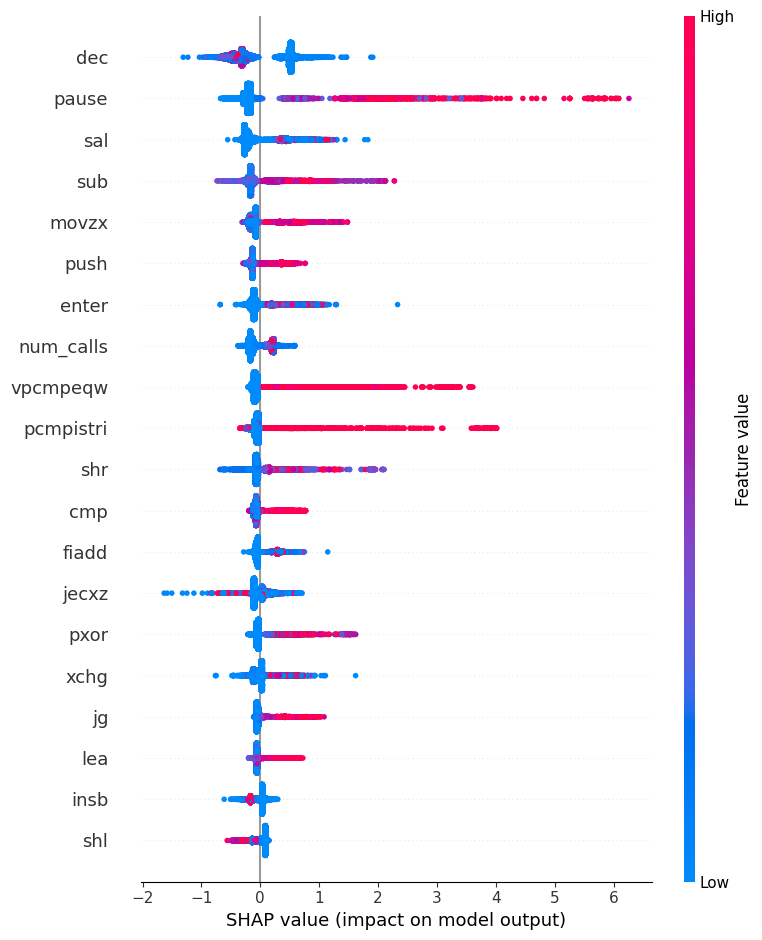

In [ ]:
import shap

y_pred = model.predict(X_test)

#it is the model corresponding to the target: 'by pass Windows File Protection'
first_label_classifier = model.estimators_[26]

# Appliquer SHAP
explainer = shap.Explainer(first_label_classifier, X_train)
shap_values = explainer.shap_values(X_train, check_additivity=False)
#shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train)

#### Local Shap

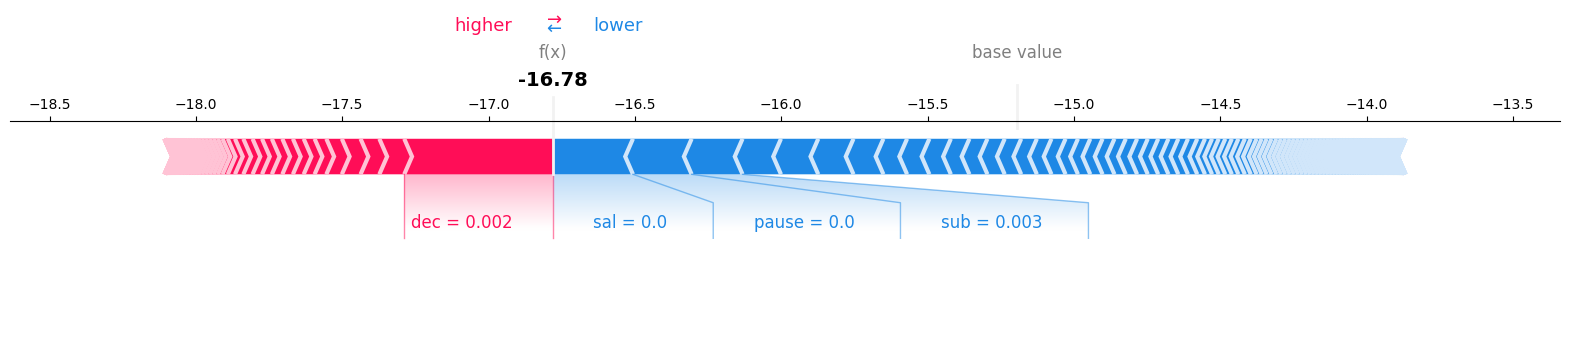

In [16]:
sample_idx = 0
sample = X_train.iloc[sample_idx:sample_idx+1]
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[3], sample.apply(lambda x : x.round(3)), matplotlib=True)

#### **PDP** - Global

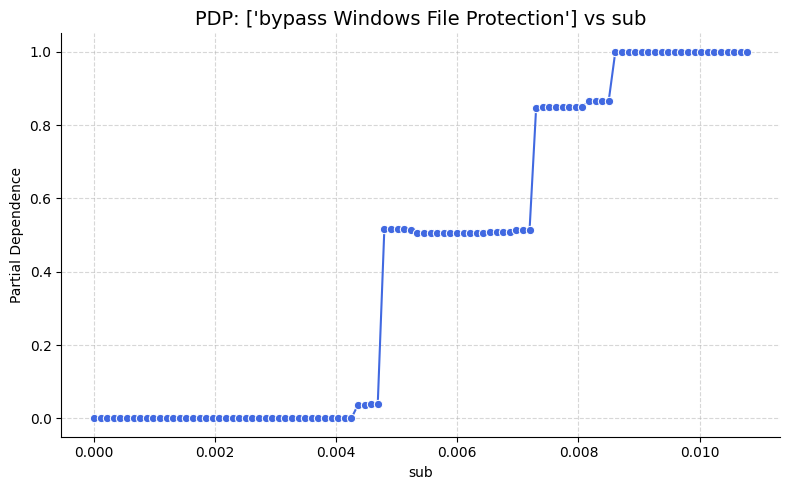

In [10]:
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence

# Choose a feature to inspect
feature_to_plot = 'sub'  # e.g., 'age', 'height', etc.
label_names= ['bypass Windows File Protection']

# Loop through each binary classifier in OVR
for i, estimator in enumerate(model.estimators_[26:27]):

    # PDP for one feature
    #PartialDependenceDisplay.from_estimator(estimator, X, [feature_to_plot])
    #plt.title(f'PDP for class: {label_names[i]} - Feature: {feature_to_plot}')
    #plt.show()
    
    # Get PDP values
    pdp_result = partial_dependence(estimator, X_test, [feature_to_plot], kind='average')

    # Extract values
    scaler = MinMaxScaler()
    
    feature_values = pdp_result['grid_values'][0]
    pdp_values = pdp_result['average'][0]
    
    # Ensure feature_values is a NumPy array
    #feature_values = np.array(pdp_result['grid_values'][0]).reshape(-1, 1)
    pdp_values = np.array(pdp_result['average'][0]).reshape(-1, 1)
    
    #feature_values_scaled = scaler.fit_transform(feature_values).flatten()
    pdp_values_scaled = scaler.fit_transform(pdp_values).flatten()

    # Put into DataFrame
    df_pdp = pd.DataFrame({
        feature_to_plot: feature_values,
        'Partial Dependence': pdp_values_scaled
    })

    # Plot with Seaborn
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=df_pdp, x=feature_to_plot, y='Partial Dependence', marker='o', color='royalblue')
    sns.despine()
    plt.title(f"PDP: {label_names} vs {feature_to_plot}", fontsize=14)
    plt.xlabel(feature_to_plot)
    plt.ylabel("Partial Dependence")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

Dans la figure precedente on présente le PDP plot pour la variable 'by pass windows File Protection'. Ce plot présente l'impacte de la valeur de cette variable sur la prédiction du modèle. Pour des faibles valeurs (plus petite que 0.008) l'impacte est faible parcontre l'impacte augmente pour les valeurs plus importantes.

#### **ALE** - Global

In [11]:
from alibi.explainers import ALE, plot_ale

In [12]:
features = X_train.columns.tolist()
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()

In [13]:
estimator_1 = model.estimators_[26]

# Alibi requires a callable that returns predictions
def predict_fn(X):
    return estimator_1.predict(X)

# Initialize ALE explainer
ale_explainer = ALE(predict_fn, feature_names=features, target_names= ['sub'])

# Fit ALE on the data
ale_exp = ale_explainer.explain(X_train_np)

In [20]:
# Configuration
feature_to_plot = 'sub'
label_names = ['bypass Windows File Protection']

# Get ALE data for the desired feature
feature_idx = X_test.columns.get_loc(feature_to_plot)
ale_feature = ale_exp.ale_values[feature_idx]
ale_grid = ale_exp.feature_values[feature_idx]

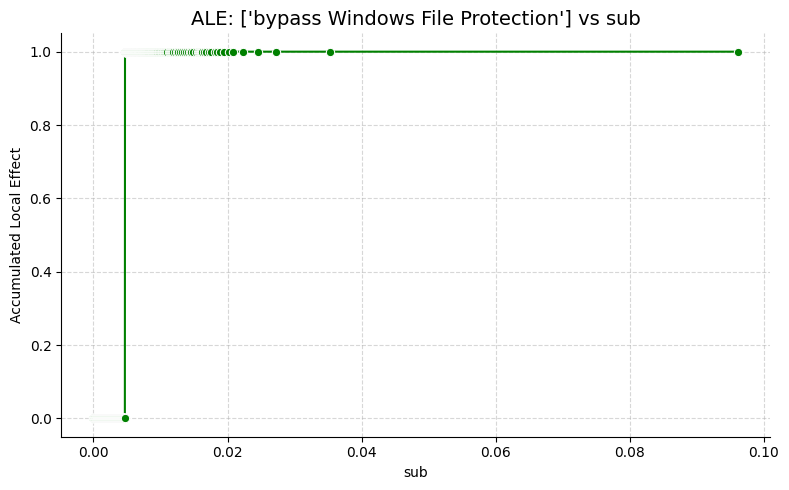

In [21]:


# Optionally scale ALE values
scaler = MinMaxScaler()
ale_scaled = scaler.fit_transform(ale_feature.reshape(-1, 1)).flatten()

# Create DataFrame for plotting
df_ale = pd.DataFrame({
    feature_to_plot: ale_grid,
    'ALE': ale_scaled
})

# Plot ALE curve
plt.figure(figsize=(8, 5))
sns.lineplot(data=df_ale, x=feature_to_plot, y='ALE', marker='o', color='green')
sns.despine()
plt.title(f"ALE: {label_names} vs {feature_to_plot}", fontsize=14)
plt.xlabel(feature_to_plot)
plt.ylabel("Accumulated Local Effect")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#### **LOFO** - Global

La méthode **LOFO (Leave One Feature Out)** est une technique d’interprétabilité qui consiste à mesurer l’importance d’une variable en réentraînant le modèle sans cette variable, puis en comparant la performance du nouveau modèle avec celle du modèle d’origine. L’idée de base est simple : si une variable est vraiment utile, sa suppression devrait dégrader les performances du modèle. À l’inverse, si elle est peu informative, l’impact sera négligeable.

L’intuition derrière LOFO est la suivante : si la suppression d’une variable entraîne un changement significative des performances prédictives, cela indique que cette variable joue un rôle important dans les prédictions. Si les performances restent similaires, cela signifie que la variable n’apporte pas d’information précieuse. Dans certains cas, on peut même observer une amélioration des performances après la suppression d’une variable, ce qui indique une importance **négative** : la variable nuisait à la qualité du modèle, peut-être en introduisant du bruit ou de la redondance.

Pour obtenir l’importance LOFO de toutes les variables, on doit réentraîner le modèle **autant de fois qu’il y a de variables**, en supprimant à chaque fois une variable différente. À chaque itération, on mesure la performance du modèle obtenu sur un jeu de test. Cette méthode est donc très intuitive et facile à mettre en œuvre, mais elle peut être **coûteuse en temps de calcul**, surtout si le modèle est complexe ou si le nombre de variables est élevé.

En résumé, LOFO fournit une estimation conditionnelle de l’importance d’une variable, car elle évalue la performance du modèle en tenant compte de l'ensemble des autres variables présentes. Elle permet de détecter les variables réellement influentes et d’identifier celles qui peuvent être retirées sans perte de performance, voire avec un gain.

**Données et Notation:**
- **Modèle entraîné** : $\hat{f}$
- **Données d'entraînement** : $(\mathbf{X}_{\text{train}}, \mathbf{y}_{\text{train}})$
- **Données de test** : $(\mathbf{X}_{\text{test}}, \mathbf{y}_{\text{test}})$
- **Fonction de perte (erreur)** : $L(y, \hat{y})$
- **Nombre d’exemples de test** : $n_{\text{test}}$

**Formumation Mathematique**:
1. Calcul de l’erreur du modèle original

On commence par mesurer l'erreur moyenne du modèle initial sur l’ensemble de test :

$$
e_{\text{orig}} = \frac{1}{n_{\text{test}}} \sum_{i=1}^{n_{\text{test}}} L\left(y_{\text{test}}^{(i)}, \hat{f}(x_{\text{test}}^{(i)})\right)
$$

2. Boucle sur chaque variable $j \in \{1, ..., p\}$

Pour chaque variable $j$ :
- Supprimer la variable $j$ des jeux de données d'entraînement et de test, pour obtenir $\mathbf{X}_{\text{train}, -j}$ et $\mathbf{X}_{\text{test}, -j}$.
- Réentraîner un nouveau modèle $\hat{f}_{-j}$ sur $(\mathbf{X}_{\text{train}, -j}, \mathbf{y}_{\text{train}})$.
- Calculer l’erreur sur le nouveau jeu de test :

$$
e_{-j} = \frac{1}{n_{\text{test}}} \sum_{i=1}^{n_{\text{test}}} L\left(y_{\text{test}}^{(i)}, \hat{f}_{-j}(x_{\text{test}, -j}^{(i)})\right)
$$

3. Calcul de l’importance LOFO

On évalue l’importance de la variable $j$ :

- **Comme un rapport** :

$$
\text{LOFO}_j = \frac{e_{-j}}{e_{\text{orig}}}
$$

- **Ou comme une différence** :

$$
\text{LOFO}_j = e_{-j} - e_{\text{orig}}
$$

Plus la valeur est élevée, plus la variable est importante (car sa suppression dégrade la performance).


4. Tri et visualisation

On trie les variables selon leurs scores $\text{LOFO}_j$ décroissants, et on les visualise (souvent sous forme de barres) avec **plot_importance**


Les avantages sont:
- **Simple et intuitive** : chaque variable est testée en conditions réelles.
- **Prise en compte des interactions** entre les variables restantes.
- Fournit une **importance conditionnelle**, contrairement aux approches univariées.
- Peut capturer des **effets nuisibles** : une variable peut avoir une importance négative si elle dégrade le modèle.
- L’implémentation peut être optimisée via du **parallélisme** ou des **sous-échantillonnages**.

Les inconvénients sont:
- **Très coûteuse en calcul** : nécessite de **réentraîner un modèle pour chaque variable**.
- Ne convient pas à des modèles très lents ou à des jeux de données très larges sans optimisation.
- Les résultats peuvent être sensibles au **choix du jeu de test**, surtout si la taille est petite.
- Peut être instable si le modèle n’est pas robuste ou si les données sont très bruitées.
- Hyperparameters tuning is unclear.





In [4]:
model_lofo = model.estimators_[26]
model_lofo 

HistGradientBoostingClassifier(class_weight='balanced', l2_regularization=0.5,
                               learning_rate=0.25, max_depth=8,
                               max_features=0.8, max_iter=400,
                               max_leaf_nodes=53, min_samples_leaf=140,
                               validation_fraction=None)

In [5]:
from lofo import LOFOImportance, Dataset, plot_importance, FLOFOImportance

In [7]:
feature_cols = X_train.columns.tolist()

df = X_train.copy()
df['bypass Windows File Protection'] = y_train['bypass Windows File Protection']

# Créer l’objet Dataset pour LOFO
dataset = Dataset(df=df, target= 'bypass Windows File Protection' , features=feature_cols)

In [20]:
# Calculer l'importance LOFO
lofo = LOFOImportance(dataset, model=model_lofo, scoring="roc_auc", cv=4)

importance_df = lofo.get_importance()

100%|██████████| 290/290 [1:45:40<00:00, 21.86s/it]


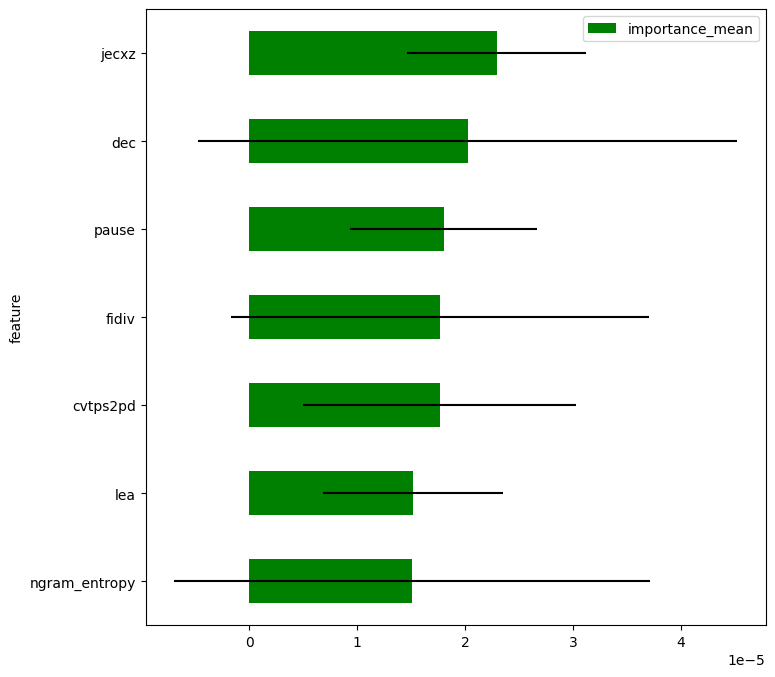

: 

In [ ]:
%matplotlib inline
plot_importance(importance_df.iloc[:7], kind ='box')

In [6]:
# Calculer l'importance LOFO
#flofo = FLOFOImportance(dataset, trained_model= model_lofo, scoring="roc_auc", cv=4)

flofo = FLOFOImportance(trained_model=model_lofo, validation_df=pd.concat([X_test, y_test], axis=1), 
                           features=X_test.columns,
                           target = 'bypass Windows File Protection',
                           scoring="roc_auc")

importance_df_f = flofo.get_importance()

100%|██████████| 290/290 [06:47<00:00,  1.41s/it]


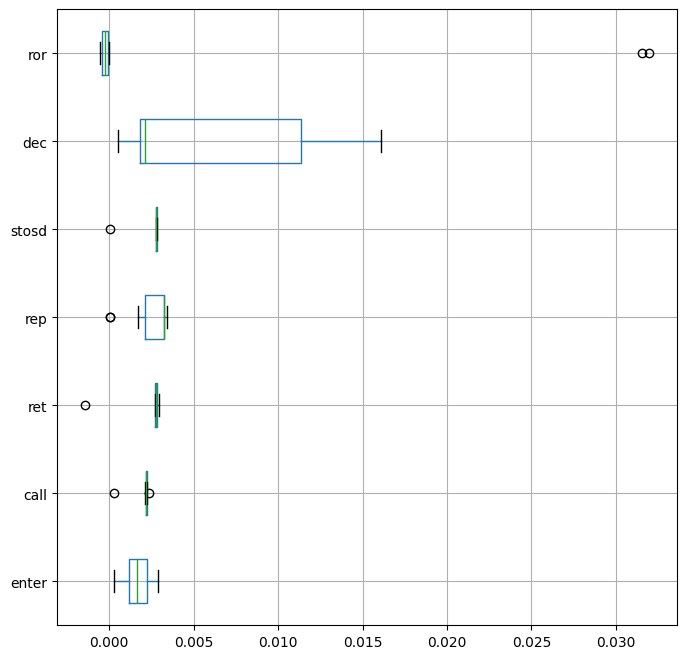

In [8]:
plot_importance(importance_df_f.iloc[:7], kind='box')

### **Local Methods**

#### **Lime** - Local

In [ ]:
from lime.lime_tabular import LimeTabularExplainer

#### **ICE** - Local

#### **Anchors** - Local